In [1]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point

In [2]:
import ee

# Trigger the authentication flow.
#ee.Authenticate()

# Initialize the library.
ee.Initialize()


In [3]:
basins = ee.FeatureCollection("users/gr_90_1-backup_ee_files-2/real_octodata")
basinsall = basins
dataset = ee.Image('WORLDCLIM/V1/BIO');
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octo_327_data')

In [23]:
def numberOfPixels(img):
    imgDescription = ee.Algorithms.Describe( img )
    height = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(0);
    width = ee.List( ee.Dictionary( ee.List(  ee.Dictionary( imgDescription ).get("bands") ).get(0) ).get("dimensions") ).get(1);
  
    print("width", width.getInfo() )
    print("height", height.getInfo() )
  
    return  ee.Number( width ).multiply( ee.Number( height ) ).getInfo()


In [24]:
import matplotlib.pyplot as plt

In [ ]:
f = gpd.read_file('/Users/gr_1/Downloads/Global_Chimaps_shp_Data_Record_A/Au_15s_Chimaps.shp')

In [18]:
a['realid'] = a.index
a.to_file('/Users/gr_1/Documents/real_octodata')

In [21]:
a.index[1]

1

In [83]:
#  Define a map centred over Oslo (Latitude: 59.9127 Longitude: 10.7461)

# First is latitude and second is longitude; both in degrees
center = (59.9127, 10.7461)



In [33]:
#def meanDictionary(geom):
    #def featurescount(feature):
        #return feature
#a = image.reduceRegions(basins,ee.Reducer.mean());
def rm_geom(feature):
    feature = feature.setGeometry(None)
    return feature
for num in range(10,11):
    #try:
    
    image2 = dataset.select('bio'+str(num));#= ee.Terrain.slope(image)
    #b2 = image2.reduceRegions(basins,ee.Reducer.percentile([20, 50, 80, 95,99]))
    b2 = image2.reduceRegions(basins,ee.Reducer.mean())
    b2=b2.map(rm_geom)
        #return a.filter(ee.Filter.notNull(['mean'])).map(featurescount)
    #b = basins.map(meanDictionary)
    mytask = ee.batch.Export.table.toDrive(collection=b2, folder='data_earth_engine', description='basins_bio_'+str(num), fileFormat='CSV')

    mytask.start()
   # except:
       # print(num)

In [32]:
mytask.active()

True

In [277]:
import geopandas as gpd
geoms=gpd.read_file('octopus_data')
import numpy as np
import pandas as pd
slp_rngs = pd.read_csv('/Users/gr_1/Downloads/basins_slope_means_0.csv')
slp_rngs = slp_rngs.drop_duplicates('smpid1')
geoms = geoms.drop_duplicates('smpid1')
slp_rngs.index = slp_rngs.smpid1
geoms.index = geoms.smpid1
geoms['slp_95_percentile'] = slp_rngs['p95']
geoms['slp_80_percentile'] = slp_rngs['p80']
geoms['slp_50_percentile'] = slp_rngs['p50']
geoms['slp_20_percentile'] = slp_rngs['p20']


In [ ]:
x = (geoms[nm]).to_numpy()
y = np.log10(geoms[nm]).to_numpy()

In [159]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns

nm = ''
ax = sns.scatterplot(data=geoms,x=nm,y='ebe_mmkyr')
ax.set_yscale('log')
x = (geoms[nm]).to_numpy()
y = np.log(geoms['ebe_mmkyr']).to_numpy()

x[np.isnan(x)]  =0
x[np.isnan(y)] = 0
y[np.isnan(y)] =0
y[np.isinf(y)] = 0


p = LinearRegression()
p.fit(x.reshape(-1,1),y.reshape(-1,1))
p2 = np.exp(x * p.coef_) * np.exp(p.intercept_)
I = np.argsort(x)
ax.plot(x[I],p2.reshape(-1,1)[I],'r')
r2_score(y[I],np.log(p2.reshape(-1,1)[I]))

In [ ]:
ax = sns.scatterplot(data=geoms,x='slp_50_percentile',y='slp_ave')


In [ ]:
distmat = np.zeros([len(geoms),len(geoms)])
slpmat = np.zeros([len(geoms),len(geoms)])
c1 = 0
for r, row in geoms.iterrows():
    print(c1)
    c2=0
    #for r2,row2 in geoms.iterrows():
    dists = np.sqrt((row.geometry.centroid.x -geoms.geometry.centroid.x) ** 2 + (row.geometry.centroid.y - geoms.geometry.centroid.y) ** 2)
    distmat[:,c1] = dists
    slpmat[:,c1] = geoms.slp_ave.to_numpy() - row.slp_ave
        #c2+=1
    c1+=1


In [198]:
distmatl = np.log(distmat)#[np.isinf(distmat)] = np.nan
distmatl[np.isinf(distmatl)] = np.nan

<ipython-input-198-987d354ef0f3>:1: RuntimeWarning: divide by zero encountered in log
  distmatl = np.log(distmat)#[np.isinf(distmat)] = np.nan


In [301]:
np.triu([[1,1],[1,1]])

array([[1, 1],
       [0, 1]])

Text(0, 0.5, 'Fraction of basins within 100 slope (m/km)')

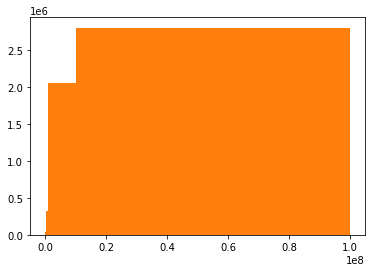

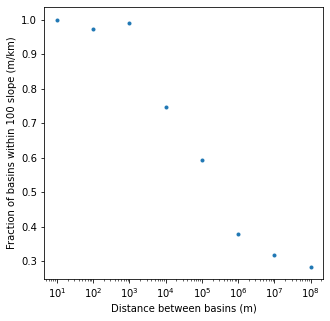

In [310]:
b = plt.hist((np.triu(distmat).ravel()[np.logical_and(np.abs(np.triu(slpmat).ravel())<100, np.abs(np.triu(slpmat).ravel())>.0001)]),bins=[0,10,100,1000,10000,100000,1000000,1e7,1e8])
b2 = plt.hist((np.triu(distmat).ravel()[np.logical_and(np.abs(np.triu(slpmat).ravel())<50000000, np.abs(np.triu(slpmat).ravel())>.0001)]),bins=[0,10,100,1000,10000,100000,1000000,1e7,1e8])

fig,ax = plt.subplots(figsize=(5,5))
plt.plot(b[1][1:],b[0]/b2[0],'.')
ax.set_xscale('log')
plt.xlabel('Distance between basins (m)')
plt.ylabel('Fraction of basins within 100 slope (m/km)')

Text(0, 0.5, 'n < 5 slope')

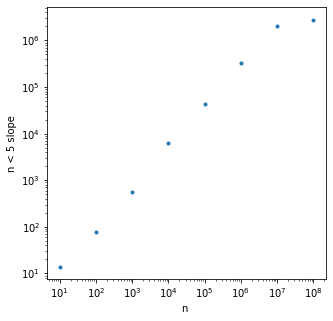

In [321]:
fig,ax = plt.subplots(figsize=(5,5))
plt.plot(b[1][1:],b2[0],'.')
ax.set_xscale('log')
ax.set_yscale('log')
#plt.plot(np.arange(1,1e7),np.arange(1,1e7))

#plt.xlabel('Distance between basins (m)')
#plt.ylabel('Fraction of basins within 10 degrees slope')

plt.xlabel('n ')
plt.ylabel('n < 5 slope')

In [351]:
bins

array([0.])

In [399]:
import numpy as np
from scipy.stats import binned_statistic
def func(x):
    y = np.mean(np.abs(x))
    return y

vals = distmat.ravel()
bins = [0,10,1e2,1e3,1e4,1e5,1e6/2,1e6*1.5/2,1e6]
results = binned_statistic(distmat.ravel() , slpmat.ravel(),statistic=func, bins=bins)[0]

In [402]:
s

NameError: name 's' is not defined

Text(0, 0.5, 'difference in Slope (avg)')

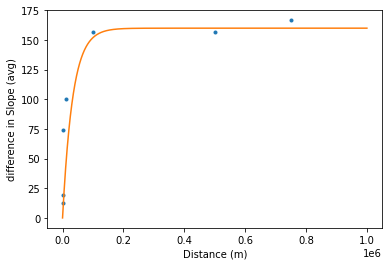

In [421]:
a = plt.plot(bins[1:-1],results[1:],'.')
#plt.xscale('log')
s = 160*(1-np.exp(-1*np.arange(1,1e6,100)/(0.1e6/3)))
plt.plot(np.arange(1,1e6,100),s)
plt.xlabel('Distance (m)')
plt.ylabel('difference in Slope (avg)')

In [75]:
b.index = b['HYBAS_ID']
bboxs = []
for i,row in b.iterrows():
    geom = np.squeeze(json.loads(row['.geo'])['coordinates'])
    try:
        p = Polygon(geom)
    except:
        try:
            p = Polygon(np.squeeze(geom[0]))
        except:
            p = Polygon(np.squeeze(geom[0][0]))
    bboxs.append(p.bounds[i])


NameError: name 'b' is not defined

In [ ]:
ee.batch.Task.list()

(array([  2861.,   2315.,    838.,   1323.,    799.,   1340.,   5251.,
         36656.,  85558., 106000.,  92802.,  63952.,  41880.,  26504.,
         17028.,   9978.,   6248.,   3852.,   1951.,   1054.]),
 array([-2.38042444e+00, -2.18224308e+00, -1.98406172e+00, -1.78588036e+00,
        -1.58769900e+00, -1.38951764e+00, -1.19133628e+00, -9.93154920e-01,
        -7.94973560e-01, -5.96792200e-01, -3.98610840e-01, -2.00429480e-01,
        -2.24811992e-03,  1.95933240e-01,  3.94114600e-01,  5.92295960e-01,
         7.90477320e-01,  9.88658680e-01,  1.18684004e+00,  1.38502140e+00,
         1.58320276e+00]),
 <BarContainer object of 20 artists>)

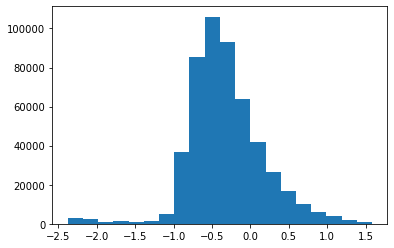

In [398]:
plt.hist(np.log10(b['maxy']-b['miny']),20)

## start

In [28]:
def meanDictionary(geom):
    return image.clip(geom.geometry())
mns = basins.map(meanDictionary)

In [ ]:
basins.getInfo()

In [14]:
import matplotlib.pyplot as plt

In [172]:

import json 
from shapely.geometry import Polygon
basin_slopes = gpd.GeoDataFrame()
basin_slopes_t = gpd.GeoDataFrame()

shps = []
for i,row in basin_slopes_0.iterrows():
    g = json.loads(basin_slopes_0.loc[0]['.geo'])
    shp = Polygon(np.squeeze(g['coordinates']))
    shps.append(shp)
    basin_slopes_t.append(row)
basin_slopes.append()
basin_slopes

In [36]:
basin_slopes_mean = pd.read_csv('/Users/gr_1/Downloads/basins_slope_means.csv')

In [65]:
basins_2 = pd.read_pickle('BASINS_ALL')


In [66]:
#basins_2['HYBAS_ID'] = basins_2.index
basins_2.index = range(len(basins_2))
basins_2['p95'] = basins_slopes['p95']
basins_2['p80'] = basins_slopes['p80']
basins_2['p50'] = basins_slopes['p50']
basins_2['p20'] = basins_slopes['p20']
basins_2['mean_slope'] = basin_slopes_mean['mean']



In [67]:
if 0: # we did it once so we can load it now
    up_basins = []
    ids = basins_2['HYBAS_ID'].values
    down_ids = basins_2['NEXT_DOWN'].values
    c=0
    def recurbas(l,c):
        c+=1
        idx = ids[down_ids==l]
        for j in idx:
            if j != l:
                if c>10000:
                    print(j,l)
                idx = np.append(idx,recurbas(j,c))

        return idx
    for i in range(len(ids)):
        up_basins.append(recurbas(ids[i],c))
        c=0
        if np.mod(i,1000) == 0:
            print(i/len(ids))

In [68]:
# basins_2 = gpd.GeoDataFrame(basins_2)
# ptgeo = []
# for i, geo in enumerate(basins_2['.geo']):
#     geo2 = ast.literal_eval(geo)
#     try:
#         ptgeo.append(Polygon(geo2['coordinates'][0]))
#     except:
#         ptgeo.append(MultiPolygon(geo2['coordinates'][0],geo2['coordinates'][1]))

In [69]:
#basins_2.geometry = ptgeo

In [70]:
# basins = gpd.GeoDataFrame()
# c=0
# for pt in pt_gpd.geometry:
#     basins = basins.append(basins_2[basins_2.contains(pt)])
#     print(len(basins))
#     print(c)
#     c+=1

In [82]:
pt_basins = pd.read_pickle('pt_basins')
a = pd.read_csv('a.csv')
pt_basins['HYBAS_ID'] = pt_basins.index

In [83]:
basins_gpd = gpd.GeoDataFrame(pt_basins,geometry = ptgeo)

In [ ]:
basins_gpd.index = basins_gpd['HYBAS_ID']
basins_2['SUB_AREA'][basins_2['p95'].isna()] = .00000000001
basins_2['p95'][basins_2['p95'].isna()] = 0
#basins_2['SUB_AREA'][basins_2['p50'].isna()] = .00000000001
basins_2['p95'][basins_2['p50'].isna()] = 0
basins_gpd['p95'] = basins_2['p95']
basins_gpd['p50'] = basins_2['p50']
basins_gpd['mean_slope'] = basins_2['mean_slope']
basins_2.index = basins_2['HYBAS_ID']
#basins_gpd['HYBAS_ID'] = basins_gpd.index
basins_gpd.index = range(len(basins_gpd))

In [ ]:
c=1
d=1
for i,pt in pt_gpd.iterrows():
    basin = basins_gpd[basins_gpd.contains(pt.geometry)]
    if len(basin) >0:
        basin = basin.iloc[0:1]
        pt_gpd.loc[i,'Basin_id'] = basin['HYBAS_ID'].values
        upstream_basins = basins_2["NEXT_UP"][basin['HYBAS_ID']].values[0]
        #if len(upstream_basins) > 0:
        basum = basins_2['mean'][upstream_basins].values
        areas = basins_2['SUB_AREA'][upstream_basins].values
        pt_gpd.loc[i,'mean_topo'] = (basin['mean'].values*basin['SUB_AREA'].values +
                                     np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                          basin['SUB_AREA'].values[0])
        basum = basins_2['p95'][upstream_basins].values

        pt_gpd.loc[i,'95_slope_mean'] = (basin['p95'].values*basin['SUB_AREA'].values +
                                     np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0])+
                                                                                          basin['SUB_AREA'].values[0])
        basum = basins_2['p50'][upstream_basins].values
        pt_gpd.loc[i,'50_slope_mean'] = (basin['p50'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0]) +
                                                                                                     basin['SUB_AREA'].values[0])
        basum = basins_2['mean_slope'][upstream_basins].values
        pt_gpd.loc[i,'mean_slope_all'] = (basin['mean_slope'].values*basin['SUB_AREA'].values +
                                         np.sum(np.multiply(basum[basum>0],areas[basum>0])))/(np.sum(areas[basum>0]) + basin['SUB_AREA'].values[0])
        if np.isnan(pt_gpd.loc[i,'50_slope_mean']):
            print('broken')
      #  print(np.sum(areas[basum>0]) +basin['SUB_AREA'].values[0])
    else:
        c+=1

In [102]:
pt_gpd['Mean Basin Slope (°)'] = pd.to_numeric(pt_gpd['Mean Basin Slope (°)'], errors='coerce')

In [3]:
plt.plot(a['Mean Basin Slope (°)'],a['slope_mean'],'.')
plt.plot(np.arange(0,40),np.arange(0,40))

NameError: name 'plt' is not defined

In [252]:
a

NameError: name 'a2' is not defined

In [87]:
#basins_slopes = pd.read_csv('/Users/gr_1/Downloads/basins_slope_percentiles.csv')
a = pd.read_csv('a.csv')

basin_slopes =[] 
for i in range(20):
    pdf = pd.read_csv('/Users/gr_1/Documents/cosmo_predict/pb_points/basins_slope_means_' + str(i) +'.csv')
    for i,row in pdf.iterrows():
        a.loc[row['id'],'slope_mean'] = row['mean']
    print(max(pdf.id))

1063
1351
1316
1271
1236
1121
967
976
1364
1380
240
333
1385
1388
555
471
619
708
730
789


In [ ]:
map.save('test.html')

In [17]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl, basemaps
from ipywidgets import HTML
m = Map(zoom=1,basemap=basemaps.OpenTopoMap)
b = a.copy();
b.geometry =  a.geometry.centroid
pt_data = GeoData(geo_dataframe = b[1:20])

#def click_handler(event=None, id=None, properties=None):
#    label.value = properties['ebe_mmkyr']

#pt_data.on_click(click_handler)

m.add_layer(pt_data)
m

<ipython-input-17-536c392833b8>:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  b.geometry =  a.geometry.centroid


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [18]:
m.save('test.html',title='test')


In [16]:
clear(b)

In [77]:
c = b[b.within(a.loc[0:1])]
c.to_file('c')

/Users/gr_1/opt/miniconda3/envs/ee/lib/python3.9/site-packages/geopandas/base.py:32: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [ ]:
def pdt(io):
    return pd.to_numeric(io,errors='coerce')
a = a.loc[np.abs(pdt(a['Basin Area (km )'] )) <20000]

a.index = range(len(a))
x = pdt(a['Mean Basin Slope (°)'])
y = pdt(a['slope_mean'])
I = np.where(np.logical_or(np.isnan(x.values),np.isnan(y.values)))[0]
x = x.drop(I)
y = y.drop(I)
mt.r2_score(x, y)

In [72]:
for i,row in a.iterrows():
    basins.geometry.area

AttributeError: 'function' object has no attribute 'area'

In [91]:
len(np.where(abs(x-y)>5)[0])

214

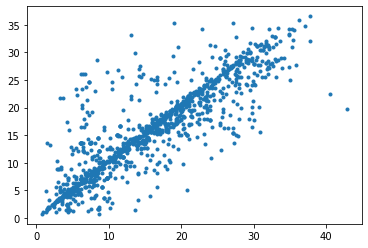

In [89]:
plt.plot(x,y,'.')

In [606]:
l.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [231]:
from sklearn.linear_model import LinearRegression

0.1782057360560888

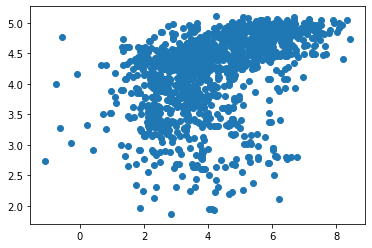

In [235]:
x = np.log(pd.to_numeric(a['slope_mean'],errors='coerce'))
y = np.log(pd.to_numeric(a['CRONUS Erosion Rate (m My)'],errors='coerce'))
I = np.where(np.logical_or(np.isnan(x.values),np.isnan(y.values)))[0]
x = x.drop(I).to_numpy()
y = y.drop(I).to_numpy()
l = LinearRegression().fit(x.reshape(-1,1),y.reshape(-1,1))
y_ = l.predict(x.reshape(-1,1))
plt.scatter(y,y_)

mt.r2_score(y, y_)

In [549]:
pt_gpd

,Unnamed: 0,Citation,Sample ID,Location,Latitude (decimal degrees),Longitude (decimal degrees),Mean Basin Elevation (m),Basin Relief (m),Basin Area (km ),Mean Latitude (decimal degrees),...,,type,dist,dist_bin,geometry,Basin_id,mean_topo,95_slope_mean,50_slope_mean,mean_slope_all
0,26,Belmont et al. (2007),Lower_EFMC,"Clearwater River, Washington, United States",47.654,-124.240,239.0,376,13.61,47.686,...,NaN,basinwide,133.065703,22,POINT (-124.24000 47.65400),7.090343e+09,341.127463,31.869465,inf,16.191463
1,525,Heimsath et al. (2001),OR-16,"Coast Range, Oregon, United States",43.469,-124.113,296.0,345,3.59,43.472,...,NaN,basinwide,131.505098,22,POINT (-124.11300 43.46900),7.090014e+09,95.408404,25.628412,inf,11.198064
2,460,NaN,ORK,"Redwood Creek at Orick, Coast Range, Californi...",41.289,-124.060,575.0,1619,720.45,41.060,...,NaN,basinwide,130.750392,22,POINT (-124.06000 41.28900),7.090014e+09,573.951708,26.369799,inf,16.075120
3,27,NaN,Upper_WC,NaN,47.739,-124.044,636.0,501,1.73,47.743,...,NaN,basinwide,132.913228,22,POINT (-124.04400 47.73900),7.090343e+09,341.127463,31.869465,inf,16.191463
4,28,NaN,Lower_WC,NaN,47.729,-124.037,563.0,606,4.22,47.746,...,NaN,basinwide,132.903103,22,POINT (-124.03700 47.72900),7.090343e+09,341.127463,31.869465,inf,16.191463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,530,NaN,NR-38,NaN,-36.667,150.000,1018.0,239,4.66,-36.636,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1386,531,NaN,NR-58,NaN,-36.667,150.000,919.0,864,23.17,-36.629,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1387,532,NaN,NR-60,NaN,-36.667,150.000,919.0,864,23.17,-36.629,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998
1388,528,Heimsath et al. (2006),NR-32,"Nunnock River Basin, Southeast Australia",-36.667,150.000,1005.0,251,5.98,-36.636,...,NaN,basinwide,154.416543,26,POINT (150.00000 -36.66700),5.090072e+09,84.175025,14.424484,inf,7.204998


[None, None]

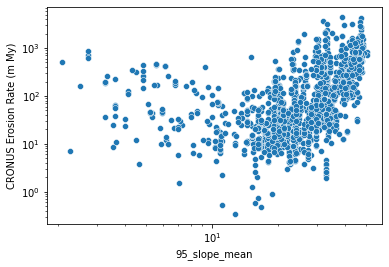

In [562]:
ax = sns.scatterplot(data=pt_gpd,x='95_slope_mean',y='CRONUS Erosion Rate (m My)')

ax.set(xscale="log", yscale="log")

[None, None]

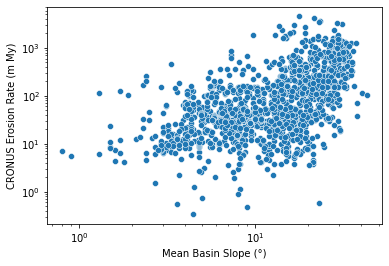

In [557]:
ax = sns.scatterplot(data=pt_gpd,x='Mean Basin Slope (°)',y='CRONUS Erosion Rate (m My)')
ax.set(xscale="log", yscale="log")